# COGS 108 - Data Checkpoint

<a id='research_question'></a>
# Research Question

*Does enrollment in secondary education reduce teenage fertility rate?*

# Dataset(s)


- Dataset Name: World Development Indicators from the World Bank
- Link to the dataset: https://datacatalog.worldbank.org/search/dataset/0037712/World-Development-Indicators
- Number of observations: 264 observations of 20 variables after wrangling

The full dataset contians country-level development indicators for 266 countries/regions around the world. There are in total 1400+ development indicators measuring economics, education, health, and demographics. Examples are real GDP per capita, education enrollment rate, fertility rate by group, and average personal income. The full data set has observation for each country from 1981 to 2016. We will only use a subset of the years and indicators.

- Dataset Name: Series Code of WDI from the World Bank
- Link to the dataset: https://datacatalog.worldbank.org/search/dataset/0037712/World-Development-Indicators
- Number of observations: 1450

This is a supplementary dataset containing the specific information including varaible code, varaible name, description, unit of measurements, etc. It specifies the indicator which appear only as name and code in the main dataset. We use this to extract variables related to secondary school education status since there are too many to examine manually. Units will be added to the dataset by a left merge to the main dataset.

# Setup

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import patsy
import statsmodels.api as sm

# Data Cleaning

<b> (1) loading and inspection </b>

In [2]:
df_full = pd.read_csv('WDI_full.csv')
var_code = pd.read_csv('var_code.csv')

In [3]:
len(pd.unique(var_code['Series Code']))

1452

In [4]:
df_full.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Arab World,ARB,"2005 PPP conversion factor, GDP (LCU per inter...",PA.NUS.PPP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"2005 PPP conversion factor, private consumptio...",PA.NUS.PRVT.PP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,75.463958,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,84.362348,NaN,86.280351,NaN,NaN,NaN,NaN
3,Arab World,ARB,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,58.696062,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,71.984231,NaN,73.917807,NaN,NaN,NaN,NaN
4,Arab World,ARB,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,91.847193,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,93.839661,NaN,95.156730,NaN,NaN,NaN,NaN


In [5]:
df_full.shape

(383328, 31)

We observe that the origional dataset is very large, the dimension being: 383328 rows $\times$ 31 columns. We would only need a subset of it, so the part we are interested in needed querying.

The dataset is not in the clea form that each observation is a row with each feature being a column: in particular, we see that each year is a column here while indicators are row entries under the 'Indicator Name' column; therefore after subsetting, we need to convert the provided wide dataset to a long dataset where each variable takes one column.

Missing entry here is recorded as NaN, we will check the data type of the missing value presented and deal with it later.

In [6]:
df_full.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016'],
      dtype='object')

In [7]:
full_checked_cols = ['Country Name', 'Country Code', 
                     'Indicator Name', 'Indicator Code', 
                     '2010', '2011', '2012', '2013', '2014', '2015', '2016']

We will only observe the recent years since our goal is to infer the possible effect of secondary school enrollment on teenage fertility rate for recent years. Years starting from 2010 are selected, up till last year available.

In [8]:
df_full_checked_cols = df_full[full_checked_cols]

<b> (2) Cross section selection </b>
<br/>We will use fixed effect regression to make the prediction model; therefore cross-sectional data will be used. We have 7 candidate years from the previous part, suitable one(s) is to be selected here.

In [9]:
teen_fert = df_full_checked_cols[df_full_checked_cols["Indicator Code"] == "SP.ADO.TFRT"]
teen_fert.head()

,Country Name,Country Code,Indicator Name,Indicator Code,2010,2011,2012,2013,2014,2015,2016
48,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,49.672975,49.536047,49.383745,48.796558,48.196418,47.550194,NaN
1500,Caribbean small states,CSS,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,61.286779,60.463396,59.559314,58.363478,57.109166,55.799601,NaN
2952,Central Europe and the Baltics,CEB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,21.088440,20.811315,20.629395,20.062750,19.519840,18.946255,NaN
4404,Early-demographic dividend,EAR,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,47.645806,46.139192,44.608416,43.132990,41.637707,40.127504,NaN
5856,East Asia & Pacific,EAS,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,19.294694,19.823676,20.366677,20.862558,21.314045,21.694045,NaN


In [10]:
for year in range(2010, 2017):
    na_rate = teen_fert[str(year)].isna().mean()
    print(str(year)+" data has na rate in fertility record of: {na_rate}".format(na_rate = na_rate))

2010 data has na rate in fertility record of: 0.09090909090909091
2011 data has na rate in fertility record of: 0.09090909090909091
2012 data has na rate in fertility record of: 0.09090909090909091
2013 data has na rate in fertility record of: 0.09090909090909091
2014 data has na rate in fertility record of: 0.09090909090909091
2015 data has na rate in fertility record of: 0.09090909090909091
2016 data has na rate in fertility record of: 1.0


In [11]:
gdp_perk = df_full_checked_cols[df_full_checked_cols["Indicator Code"] == "NY.GDP.PCAP.CD"]
gdp_perk
for year in range(2010, 2017):
    na_rate = gdp_perk[str(year)].isna().mean()
    print(str(year)+" data has na rate in GDP record of: {na_rate}".format(na_rate = na_rate))

2010 data has na rate in GDP record of: 0.07196969696969698
2011 data has na rate in GDP record of: 0.07196969696969698
2012 data has na rate in GDP record of: 0.08712121212121213
2013 data has na rate in GDP record of: 0.08333333333333333
2014 data has na rate in GDP record of: 0.10606060606060606
2015 data has na rate in GDP record of: 0.13636363636363635
2016 data has na rate in GDP record of: 1.0


We inspect the missingness in the two most important variables: the key control variable - teenage fertility rate, and the outcome variable - teenage fertility rate. We therefore select the most recent year with the least combined missingness: 2013

In [12]:
df_2013 = df_full_checked_cols[['Country Name', 'Country Code', 
                     'Indicator Name', 'Indicator Code', '2013']]

In [13]:
df_2013.head()

,Country Name,Country Code,Indicator Name,Indicator Code,2013
0,Arab World,ARB,"2005 PPP conversion factor, GDP (LCU per inter...",PA.NUS.PPP.05,NaN
1,Arab World,ARB,"2005 PPP conversion factor, private consumptio...",PA.NUS.PRVT.PP.05,NaN
2,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN
3,Arab World,ARB,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN
4,Arab World,ARB,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,NaN


In [14]:
len(pd.unique(df_2013['Indicator Name']))

1452

<b> (3) Appending Unit </b>

In [15]:
unit_code = var_code[['Series Code', 'Unit of measure']]

In [16]:
unit_code.columns = ['Indicator Code', 'Unit']

In [17]:
pd.unique(unit_code['Unit'])

array([nan, '%', '2011 PPP $'], dtype=object)

There are 3 unique units, two of which are not void. We will merge it to our main dataset so that units are included.

In [18]:
df_2013_unit = df_2013.merge(unit_code, left_on = 'Indicator Code', right_on = 'Indicator Code')
df_2013_unit

,Country Name,Country Code,Indicator Name,Indicator Code,2013,Unit
0,Arab World,ARB,"2005 PPP conversion factor, GDP (LCU per inter...",PA.NUS.PPP.05,NaN,NaN
1,Caribbean small states,CSS,"2005 PPP conversion factor, GDP (LCU per inter...",PA.NUS.PPP.05,NaN,NaN
2,Central Europe and the Baltics,CEB,"2005 PPP conversion factor, GDP (LCU per inter...",PA.NUS.PPP.05,NaN,NaN
3,Early-demographic dividend,EAR,"2005 PPP conversion factor, GDP (LCU per inter...",PA.NUS.PPP.05,NaN,NaN
4,East Asia & Pacific,EAS,"2005 PPP conversion factor, GDP (LCU per inter...",PA.NUS.PPP.05,NaN,NaN
...,...,...,...,...,...,...
383323,Virgin Islands (U.S.),VIR,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS,NaN,NaN
383324,West Bank and Gaza,WBG,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS,99.348427,NaN
383325,"Yemen, Rep.",YEM,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS,NaN,NaN
383326,Zambia,ZMB,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS,NaN,NaN


Atfer the first few steps of wrangling, we have the desired time span of 2013 and unit included as a column. The remaining tasks would be to reshape the dataset so that each variable takes a column while each observation is a row. When done with wrangling, we should have a dataset whose number of rows equals to the numbers of countries.

<b> (4) Variable screening selection </b>

In [19]:
teen_fert_code = "SP.ADO.TFRT"
gdp_pk_code = "NY.GDP.PCAP.CD"
trained_sec_tch = "SE.SEC.TCAQ.FE.ZS"
#manually adding trained secondary teacher percentage

*We checked the supplmentary dataset for variable names and manually added those variables*

In [20]:
def check_secondary(str_in):
    str_in = str_in.lower()
    return ("secondary" in str_in and "school" in str_in)

*we now check and seek for all possible relavent variables with the condition that the indicator name contains two key words: "school" and "secondary", though consecutive occurance is now enforced.*

In [21]:
sec_educ_var = var_code[var_code["Indicator Name"].apply(check_secondary)][["Series Code", "Indicator Name"]]

In [22]:
sec_educ_var_code = sec_educ_var["Series Code"].tolist()

In [23]:
sec_educ_var_code.append(teen_fert_code)
sec_educ_var_code.append(gdp_pk_code)
sec_educ_var_code.append(trained_sec_tch)

var_ref = var_code[['Series Code', 'Indicator Name']]
var_ref = var_ref[var_ref['Series Code'].isin(sec_educ_var_code)]
var_ref

,Series Code,Indicator Name
805,NY.GDP.PCAP.CD,GDP per capita (current US$)
876,SE.ENR.PRSC.FM.ZS,"School enrollment, primary and secondary (gros..."
877,SE.ENR.SECO.FM.ZS,"School enrollment, secondary (gross), gender p..."
937,SE.SEC.AGES,Lower secondary school starting age (years)
960,SE.SEC.ENRR,"School enrollment, secondary (% gross)"
961,SE.SEC.ENRR.FE,"School enrollment, secondary, female (% gross)"
962,SE.SEC.ENRR.MA,"School enrollment, secondary, male (% gross)"
963,SE.SEC.NENR,"School enrollment, secondary (% net)"
964,SE.SEC.NENR.FE,"School enrollment, secondary, female (% net)"
965,SE.SEC.NENR.MA,"School enrollment, secondary, male (% net)"


*from the sup-dataset we have selected the following variables, their codes and names are presented above.*

In [24]:
var_ref = var_ref.drop([876, 962, 877, 966, 967, 968, 982, 983, 984,963,964,965])
sec_educ_var_code = var_ref['Series Code'].tolist()
#dropping before screening

*we pre-select the datasets with respect to the assumptions of regression, mainly variables deleted here are due to multi-colinearity and irrelavance information.*
<br/>
<br/>
*Specifically, for variables in paris of male and female measurement, there are almost perfectly linearly related by male% + female% = 1; therefore, only female-related indices are kept.*
<br/>
<br/>*irrelavent varaibles happen to satisfy our screening condition are also deleted.*

In [25]:
df_2013_unit = df_2013_unit[df_2013_unit["Indicator Code"].isin(sec_educ_var_code)]
df_2013_unit.head()

,Country Name,Country Code,Indicator Name,Indicator Code,2013,Unit
12672,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,48.796558,NaN
12673,Caribbean small states,CSS,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,58.363478,NaN
12674,Central Europe and the Baltics,CEB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,20.062750,NaN
12675,Early-demographic dividend,EAR,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,43.132990,NaN
12676,East Asia & Pacific,EAS,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,20.862558,NaN


*only selected and relavent variables are left in df_2013_unit, the task left is to shape-transform the data*

<b> (5) Reshaping dataset: from Wide to Long </b>

In [26]:
teenM = df_2013_unit[df_2013_unit["Indicator Code"] == teen_fert_code]
teenM

,Country Name,Country Code,Indicator Name,Indicator Code,2013,Unit
12672,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,48.796558,NaN
12673,Caribbean small states,CSS,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,58.363478,NaN
12674,Central Europe and the Baltics,CEB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,20.062750,NaN
12675,Early-demographic dividend,EAR,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,43.132990,NaN
12676,East Asia & Pacific,EAS,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,20.862558,NaN
...,...,...,...,...,...,...
12931,Virgin Islands (U.S.),VIR,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,45.736600,NaN
12932,West Bank and Gaza,WBG,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,60.181600,NaN
12933,"Yemen, Rep.",YEM,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,63.731800,NaN
12934,Zambia,ZMB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,98.173800,NaN


In [27]:
teenMelted = pd.melt(teenM, id_vars=['Country Name', 'Country Code'], 
                     value_vars = ["2013"], value_name = "fetility rate")
teenMelted = teenMelted.drop(columns = "variable")
teenMelted

,Country Name,Country Code,fetility rate
0,Arab World,ARB,48.796558
1,Caribbean small states,CSS,58.363478
2,Central Europe and the Baltics,CEB,20.062750
3,Early-demographic dividend,EAR,43.132990
4,East Asia & Pacific,EAS,20.862558
...,...,...,...
259,Virgin Islands (U.S.),VIR,45.736600
260,West Bank and Gaza,WBG,60.181600
261,"Yemen, Rep.",YEM,63.731800
262,Zambia,ZMB,98.173800


*The above section demonstrates how we deal with a single-var-case (example here be extracting teenage mother percentage from the dataset) of shape transformation, the technique used here is to melt the dataset with resepct to country name and country code (as they are in pairs unique to each observation). After melting, the extra column created would be the 'variable' column which holds the actual measurement in pre-transformed data format, so it is dropped.*

In [28]:
df_2013_melted = teenMelted

In [29]:
for var in pd.unique(df_2013_unit["Indicator Code"]).tolist():
    sub_curr_var = df_2013_unit[df_2013_unit["Indicator Code"] == var]
    var_melted = pd.melt(sub_curr_var, id_vars=['Country Name', 'Country Code'], 
                     value_vars = ["2013"], value_name = var)
    var_melted = var_melted.drop(columns = "variable")
    df_2013_melted = df_2013_melted.merge(var_melted, 
                                          left_on = ["Country Code", "Country Name"], 
                                          right_on = ["Country Code", "Country Name"])

*iterate through each variable and merge the dataset gradually to form the final dataset*

In [30]:
df_2013_melted

,Country Name,Country Code,fetility rate,SP.ADO.TFRT,SE.SEC.PROG.ZS,NY.GDP.PCAP.CD,SE.SEC.ENRR,SE.SEC.AGES,SE.SEC.TCAQ.FE.ZS,SE.SEC.ENRR.FE
0,Arab World,ARB,48.796558,48.796558,86.762436,7518.692984,70.274689,NaN,83.056610,67.672501
1,Caribbean small states,CSS,58.363478,58.363478,93.207108,9852.948900,79.585167,NaN,62.831612,82.432693
2,Central Europe and the Baltics,CEB,20.062750,20.062750,98.996262,13704.000920,103.608993,NaN,NaN,102.698448
3,Early-demographic dividend,EAR,43.132990,43.132990,NaN,3318.558706,69.978851,NaN,NaN,69.859428
4,East Asia & Pacific,EAS,20.862558,20.862558,93.983688,9447.878610,88.867348,NaN,NaN,88.965439
...,...,...,...,...,...,...,...,...,...,...
259,Virgin Islands (U.S.),VIR,45.736600,45.736600,NaN,NaN,NaN,NaN,NaN,NaN
260,West Bank and Gaza,WBG,60.181600,60.181600,99.448181,2992.200995,82.538620,10.0,100.000000,86.394127
261,"Yemen, Rep.",YEM,63.731800,63.731800,NaN,1582.849252,48.624660,12.0,NaN,39.502151
262,Zambia,ZMB,98.173800,98.173800,NaN,1839.518709,NaN,14.0,NaN,NaN


<b> (6) Variables re-encoding </b>

In [31]:
var_ref

,Series Code,Indicator Name
805,NY.GDP.PCAP.CD,GDP per capita (current US$)
937,SE.SEC.AGES,Lower secondary school starting age (years)
960,SE.SEC.ENRR,"School enrollment, secondary (% gross)"
961,SE.SEC.ENRR.FE,"School enrollment, secondary, female (% gross)"
969,SE.SEC.PROG.ZS,Progression to secondary school (%)
970,SE.SEC.TCAQ.FE.ZS,"Trained teachers in secondary education, femal..."
1303,SP.ADO.TFRT,"Adolescent fertility rate (births per 1,000 wo..."


In [32]:
var_ref["var_name"] = ["gdp", "sec_start", "sec_enrl","sec_enrl_fm", "prgs", "tr_teach", "frt"]
var_ref

,Series Code,Indicator Name,var_name
805,NY.GDP.PCAP.CD,GDP per capita (current US$),gdp
937,SE.SEC.AGES,Lower secondary school starting age (years),sec_start
960,SE.SEC.ENRR,"School enrollment, secondary (% gross)",sec_enrl
961,SE.SEC.ENRR.FE,"School enrollment, secondary, female (% gross)",sec_enrl_fm
969,SE.SEC.PROG.ZS,Progression to secondary school (%),prgs
970,SE.SEC.TCAQ.FE.ZS,"Trained teachers in secondary education, femal...",tr_teach
1303,SP.ADO.TFRT,"Adolescent fertility rate (births per 1,000 wo...",frt


In [33]:
col_name_dict = dict()
for code in var_ref["Series Code"].tolist():
    col_name_dict[code] = var_ref[var_ref["Series Code"] == code]["var_name"].values[0]
col_name_dict["NY.GDP.PCAP.CD"]

'gdp'

*we rename the dataset by dictionary created from the reference table earlier*

In [34]:
df_2013_melted = df_2013_melted.rename(columns = col_name_dict)


*The above is how the final dataset looks like: $264\times 10$ with variables renamed*
<br/>
<br/>
*Note: the NaN entries are kept at the current stage on purpose since we think further investigation is required to deal with them in case there are certain partterns in the missingness of the data

In [35]:
df_2013_melted = df_2013_melted.drop(columns = ['fetility rate'])
#dropping a duplicate column

# Data Analysis & Results (EDA)

<b> (I) Variable Screening </b> 
<br/>
*We will start by a first-round screening of the variables where potential correlation of variables are to be checked by graphical presentation (eg. scatter plots) and simple linear regression. Note that during the initial steps, we will only consider simple pairing of variables: that is to only examine two variables at a time, which is subject to omitted variable bias.*

(I.1) pairplot
<br/>
*Recall that our goal is to estimate the potential effect of secondary education on the teenage fertility rate, and hope fully discover a statistically significant negative correlation between them. We do the following classification of variables*

| Type  | Variable | Description |
|:-|:-|:- |
| Outcome variable  |  Teenage Fertility Rate | the dependent variable of interest |
| Explanatory variable | Secondary Education Enrollment Rate| the independent variable of interest, whose effect size is to be estiamted|
| Controll variable | GDP (etc.) | Other variables that are potentially correlated with teenage fertility rate and secondary school enrollment |

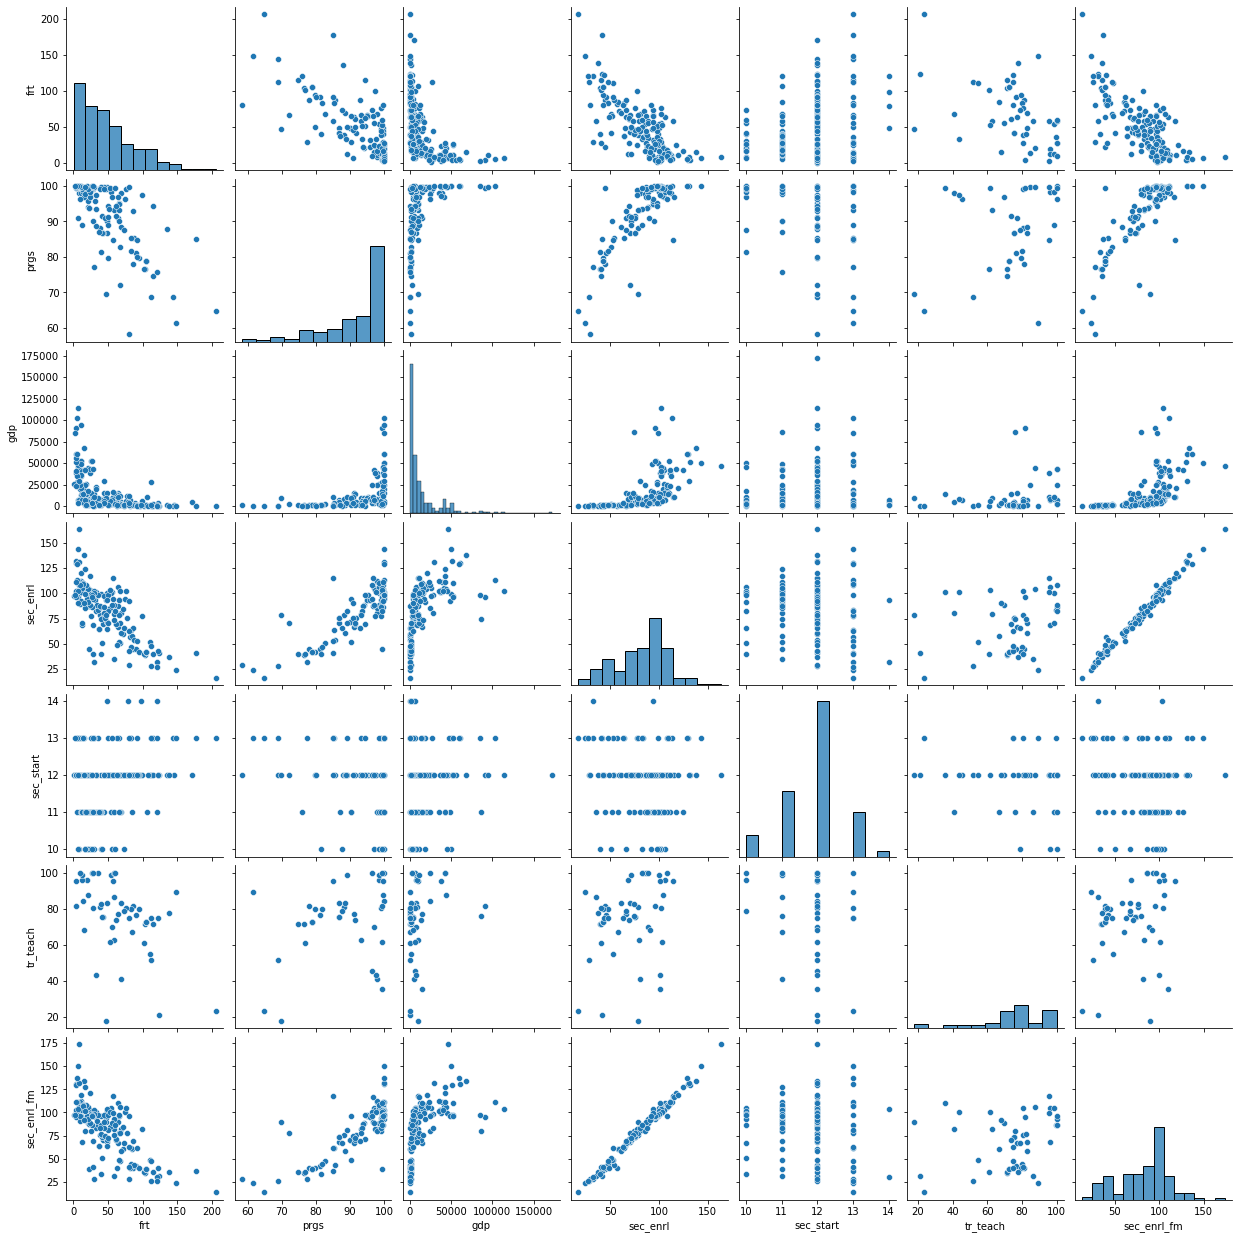

In [36]:
sns.pairplot(df_2013_melted)

*From the above plots we observe that it is not rare that the variables we selected feature pair-wise correlation. The followings are reasons why:*
<br/> &emsp; 1. Expected multicolinearity: variavles that are by nature correlated such as gross secondary education enrollment rate and that of only female students
<br/> &emsp; 2. Backed-up assumptions: we start with several assumptions based on which we choose the control variables. For example, we expect richer regions to allow higher secondary education enrollment, which is shown by the scatter plot in cell (4,3) above.

(I.1.1) Feature Engineering: GDP to log GDP
<br/>
*We want to stress that the nature of the natural logarithmic distribution of gdp across the contry, where there is a intensive cluserting at low level of GDP. And the subsequent effect can also be reflected on its correlation with other variables. We therefore will take a log-transformation on GDP, which will also influence the interpretation of our model later. (Natural log used here)*

In [37]:
df_2013_melted['log_gdp'] = np.log(df_2013_melted['gdp'])
df_2013_clean = df_2013_melted.drop(columns = ['gdp'])
#raw GDP record replaced with log-gdp

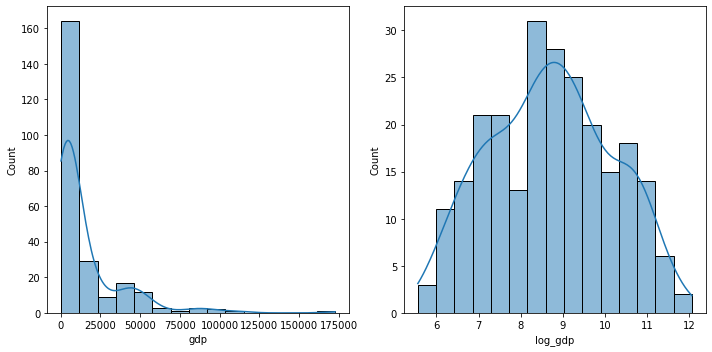

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.histplot(df_2013_melted['gdp'], ax=axes[0], bins = 15, kde= True)
sns.histplot(df_2013_clean['log_gdp'], ax=axes[1], bins = 15, kde= True)
fig.tight_layout()
fig.show()

*Plotting the distribution of the GDP and log GDP side by side, we could tell the effect of such transformation. The origional distribution of gdp is highly right-skewed while the log-transformed gdp has an overall bell shape.*
<br/>
*The following is the pair plot after feature engineering, additional columns and rows at the end.*

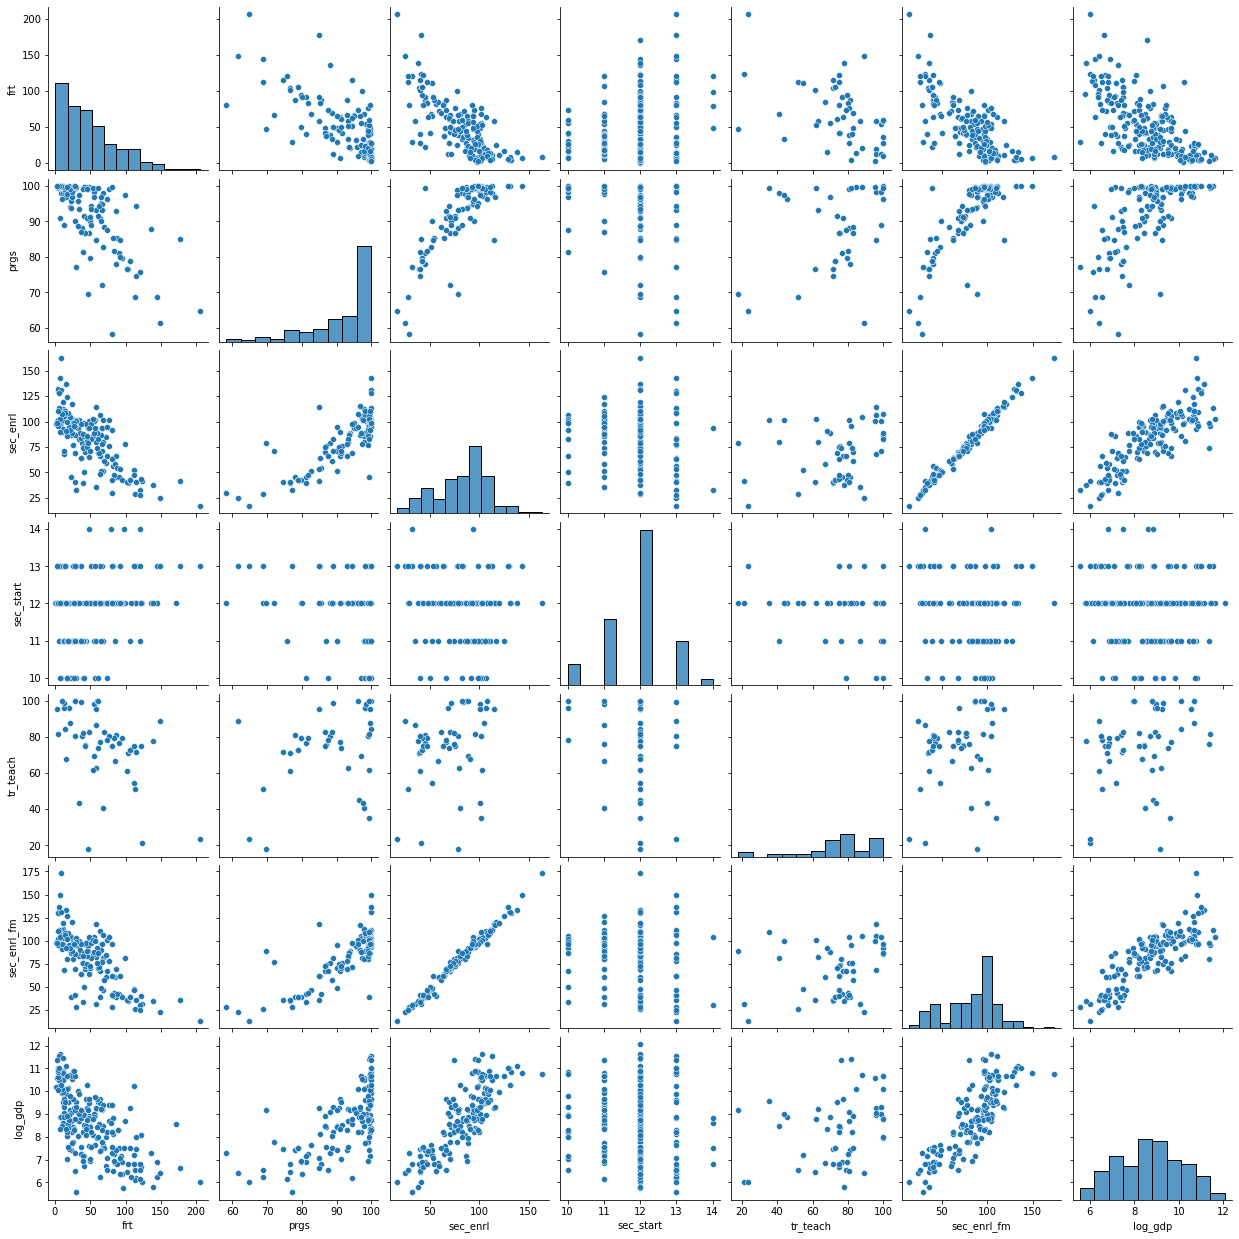

In [39]:
sns.pairplot(df_2013_clean)

*Now the correlation with log-transformed GDP with other variables, especially secondary school enrollment, are more notably linear.*

(I.1) Heatmap
*For a better-supported first round screening, we use a heatmap of correlation coefficients to numerically represent the correlation for each variable pair. Check below:*

<AxesSubplot:>

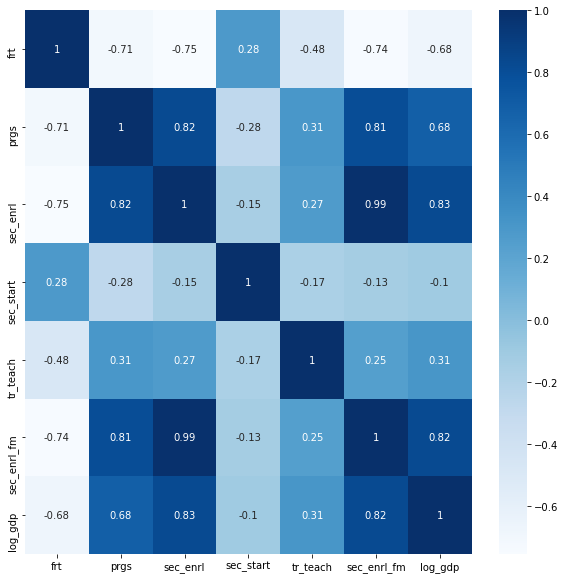

In [40]:
plt.figure(figsize=(10,10))
sns.heatmap(df_2013_clean.drop(columns = ['Country Name', 'Country Code']).corr()
            , cbar = True, annot = True, cmap='Blues')

*The results are in line with our assumptions. We want to stress that at this preliminary stage, there is a relatively strong correlation between: secondary school enrollment and log GDP (that be positive), secondary school enrollment and teenage fertility rate (that be negative).*

<b> (II) Missing and Abnormal data </b> 

(II.1) summary statistics
<br/>
the followings are the descriptive statistics of all variables

In [41]:
summary_2013 = df_2013_clean.describe()
summary_2013

,frt,prgs,sec_enrl,sec_start,tr_teach,sec_enrl_fm,log_gdp
count,240.000000,133.000000,178.000000,205.000000,58.000000,175.000000,242.000000
mean,49.315616,92.163247,83.021839,11.819512,75.173359,82.859363,8.700816
std,38.676686,9.332699,26.431101,0.846915,20.211903,28.214420,1.443488
min,0.599400,58.192509,16.807381,10.000000,17.878321,13.596250,5.558237
25%,17.602900,87.983589,66.094612,11.000000,70.094856,67.345364,7.512969
50%,40.981200,96.329437,88.365326,12.000000,77.484203,89.344879,8.724070
75%,71.896950,99.386528,101.187798,12.000000,87.387751,101.327084,9.661093
max,206.045000,99.990913,163.101013,14.000000,100.000000,173.737335,12.058518


(II.2) missingness: variable-wise check

In [42]:
null_notice = "[{col}] has [{pct}%] null entry"
for col in df_2013_clean.columns:
    pct_null = df_2013_clean[col].isnull().sum()/df_2013_clean.shape[0]
    pct_null *= 100
    
    print(null_notice.format(col = col, pct = pct_null.round(2)))

[Country Name] has [0.0%] null entry
[Country Code] has [0.0%] null entry
[frt] has [9.09%] null entry
[prgs] has [49.62%] null entry
[sec_enrl] has [32.58%] null entry
[sec_start] has [22.35%] null entry
[tr_teach] has [78.03%] null entry
[sec_enrl_fm] has [33.71%] null entry
[log_gdp] has [8.33%] null entry


*From the above result, we observe the systematic missing (about 78%) data in the record of tr_teach, which is percentage of trained teacher in secondary education. Also there are nealy 50% missing entries of prgs, progression to secondary education. We will refer back to the heatmap and pair plot to access the appropriateness of removal of these 2 features later. For now our solution would be not to include prgs in computing our model.*

(II.3) missingness: observation-wise check

In this subsection, we are to explore missingness per observation: that is to answer the question of whether country that features more missing value differ than those with more complete data.

In [43]:
df_missing = df_2013_clean
df_missing['missing_f_count'] = df_2013_clean.isnull().sum(axis = 1)
df_missing.head()

,Country Name,Country Code,frt,prgs,sec_enrl,sec_start,tr_teach,sec_enrl_fm,log_gdp,missing_f_count
0,Arab World,ARB,48.796558,86.762436,70.274689,NaN,83.056610,67.672501,8.925148,1
1,Caribbean small states,CSS,58.363478,93.207108,79.585167,NaN,62.831612,82.432693,9.195526,1
2,Central Europe and the Baltics,CEB,20.062750,98.996262,103.608993,NaN,NaN,102.698448,9.525443,2
3,Early-demographic dividend,EAR,43.132990,NaN,69.978851,NaN,NaN,69.859428,8.107286,3
4,East Asia & Pacific,EAS,20.862558,93.983688,88.867348,NaN,NaN,88.965439,9.153546,2


<AxesSubplot:xlabel='missing_f_count', ylabel='Count'>

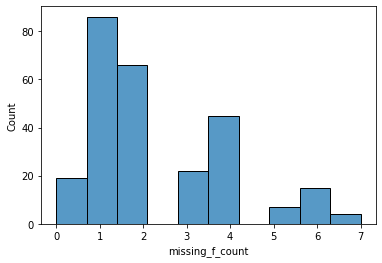

In [44]:
sns.histplot(df_missing['missing_f_count'])

By plotting the distribution of missingness, we see that most of the observations are missing less than 5 entry; we threfore set the threshold to be 5: then compare the countries with more than 5 entries missing to the rest of the data. Let's check which observation are those

In [45]:
df_missing[df_missing['missing_f_count'] >= 5]

,Country Name,Country Code,frt,prgs,sec_enrl,sec_start,tr_teach,sec_enrl_fm,log_gdp,missing_f_count
33,Not classified,INX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
50,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
56,Aruba,ABW,24.8420,NaN,NaN,12.0,NaN,NaN,NaN,5
83,Cayman Islands,CYM,NaN,NaN,NaN,11.0,NaN,NaN,NaN,6
86,Channel Islands,CHI,7.6044,NaN,NaN,NaN,NaN,NaN,NaN,6
111,Faroe Islands,FRO,NaN,NaN,NaN,NaN,NaN,NaN,10.898919,6
115,French Polynesia,PYF,37.3194,NaN,NaN,NaN,NaN,NaN,NaN,6
121,Gibraltar,GIB,NaN,NaN,NaN,11.0,NaN,NaN,NaN,6
123,Greenland,GRL,NaN,NaN,NaN,NaN,NaN,NaN,10.664943,6
125,Guam,GUM,49.4576,NaN,NaN,NaN,NaN,NaN,NaN,6


*We mannually investigated those countries and found the following reason for possible missing entry: (given by index)*
<br/> &emsp; 1. Listing of none-country entity: 33, 50, 83, 86, 111, 187, 192, 247, 259
<br/> &emsp; 2. Complete missing record: 33, 50, 229
<br/> We will do clustered scatter plot to check the pattern. For countries with more than 5 missing entry, we mark them with a dummy variable missing_5 as 1, while 0 elsewise.

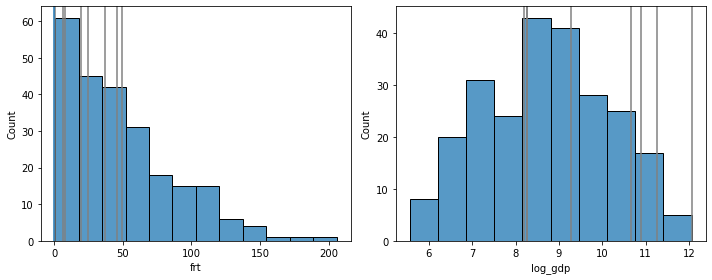

In [46]:
df_missing['missing_5'] = df_missing['missing_f_count'] >= 5

fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.histplot(data = df_missing['frt'], ax=axes[0])
sns.histplot(data = df_missing['log_gdp'], ax=axes[1])

missing_frt = df_missing[df_missing['missing_f_count'] >= 5]['frt']
missing_log_gdp = df_missing[df_missing['missing_f_count'] >= 5]['log_gdp']

for f in missing_frt[missing_frt.notna()]:
    axes[0].axvline(f, color = 'grey')

for g in missing_log_gdp[missing_log_gdp.notna()]:
    axes[1].axvline(g, color = 'grey')
    
axes[0].axvline()
fig.tight_layout()
fig.show()


*We could observe that for missing_5 datas, the contries tend to be thos with lower teenage fertility rate, and those with higher gdp; this is a reminder in the following investigation that the missing data may exhibit some pattern such that the low-frt and high-gdp pairs are missing in our dataset.*

*For now, we will remove those observation from the dataset since they do not contain record of frt, our outcome variable, and therefore should not be included in regression analysis.*

In [47]:
df_2013_clean = df_2013_clean[df_missing['missing_5']==False]
df_2013_clean.head()

,Country Name,Country Code,frt,prgs,sec_enrl,sec_start,tr_teach,sec_enrl_fm,log_gdp,missing_f_count,missing_5
0,Arab World,ARB,48.796558,86.762436,70.274689,NaN,83.056610,67.672501,8.925148,1,False
1,Caribbean small states,CSS,58.363478,93.207108,79.585167,NaN,62.831612,82.432693,9.195526,1,False
2,Central Europe and the Baltics,CEB,20.062750,98.996262,103.608993,NaN,NaN,102.698448,9.525443,2,False
3,Early-demographic dividend,EAR,43.132990,NaN,69.978851,NaN,NaN,69.859428,8.107286,3,False
4,East Asia & Pacific,EAS,20.862558,93.983688,88.867348,NaN,NaN,88.965439,9.153546,2,False


(II.4) Abnormal entry/Outliter Analysis
<br/> 
We will use Q1,3 +/- 1.5IQR formula to detect outliers, the following is the example of how we detect outlier in fertility rate. (Note that the lower bound is lower than 0 the theoratical lower bound, therefore only checked one side)

In [48]:
df_outlier = df_2013_clean
df_outlier['otlr'] = ""

/tmp/ipykernel_1676/3942195595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier['otlr'] = ""


In [49]:
frt_iqr = summary_2013['frt']['75%'] - summary_2013['frt']['25%']
u_b = summary_2013['frt']['75%'] + 1.5*frt_iqr
l_b = summary_2013['frt']['25%'] - 1.5*frt_iqr
(l_b, u_b)
idx = df_2013_clean[df_2013_clean['frt'] > u_b].index

df_outlier.iloc[idx]

,Country Name,Country Code,frt,prgs,sec_enrl,sec_start,tr_teach,sec_enrl_fm,log_gdp,missing_f_count,missing_5,otlr
54,Argentina,ARG,63.9136,NaN,106.323143,12.0,NaN,110.274757,9.474795,2,False,
188,New Zealand,NZL,24.6234,NaN,117.223488,11.0,NaN,120.817070,10.667282,2,False,
211,Sao Tome and Principe,STP,86.8800,92.953369,65.914200,12.0,NaN,69.155952,7.415117,1,False,


In [50]:
otlr_dict = dict()
for col in summary_2013.columns:
    iqr = summary_2013[col]['75%'] - summary_2013[col]['25%']
    u_b = summary_2013[col]['75%'] + 1.5*iqr
    l_b = summary_2013[col]['25%'] - 1.5*iqr
    idx_u = df_outlier[df_outlier[col] > u_b].index
    idx_l = df_outlier[df_outlier[col] < l_b].index
    
    for u in idx_u:
        if u not in otlr_dict:
            otlr_dict[u] = []
            otlr_dict[u].append(('u_' + col))
        else:
            otlr_dict[u].append(('u_' + col))
    for l in idx_l:
        if l not in otlr_dict:
            otlr_dict[l] = []
            otlr_dict[l].append(('l_' + col))
        else:
            otlr_dict[l].append(('l_' + col))
         #df_outlier.at[u, 'otlr'] = df_outlier.iloc[u] + ',' + ('u_' + col)
    
    #df_outlier.at[idx_u, 'otlr'] = ('u_' + col)
    #df_outlier.at[idx_l, 'otlr'] = ('l_' + col)
otlr_dict

{52: ['u_frt'],
 169: ['u_frt'],
 190: ['u_frt', 'l_prgs', 'l_tr_teach', 'l_sec_enrl_fm'],
 77: ['l_prgs'],
 127: ['l_prgs'],
 172: ['l_prgs'],
 181: ['l_prgs'],
 232: ['l_prgs', 'l_tr_teach'],
 65: ['u_sec_enrl', 'u_sec_enrl_fm'],
 183: ['u_sec_start'],
 223: ['u_sec_start'],
 238: ['u_sec_start'],
 262: ['u_sec_start'],
 66: ['l_tr_teach'],
 91: ['l_tr_teach'],
 124: ['l_tr_teach'],
 227: ['l_tr_teach']}

In [51]:
for k,v in otlr_dict.items():
    out_status = '；'.join(v)
    df_outlier.at[k, 'otlr'] = out_status
df_outlier[df_outlier['otlr']!='']

,Country Name,Country Code,frt,prgs,sec_enrl,sec_start,tr_teach,sec_enrl_fm,log_gdp,missing_f_count,missing_5,otlr
52,Angola,AGO,171.2734,NaN,NaN,12.0,NaN,NaN,8.580571,4,False,u_frt
65,Belgium,BEL,8.6962,NaN,163.101013,12.0,NaN,173.737335,10.747382,2,False,u_sec_enrl；u_sec_enrl_fm
66,Belize,BLZ,68.2110,97.894997,80.163040,11.0,40.783409,81.800331,8.460325,0,False,l_tr_teach
77,Burkina Faso,BFA,112.6558,68.740540,28.365730,12.0,51.488350,25.964701,6.548699,0,False,l_prgs
91,"Congo, Dem. Rep.",ZAR,123.6202,NaN,40.993671,12.0,21.183241,31.359369,6.025131,1,False,l_tr_teach
124,Grenada,GRD,33.4268,97.510246,101.139801,12.0,43.487862,100.123360,8.981699,0,False,l_tr_teach
127,Guinea,GIN,143.7726,68.785683,NaN,13.0,NaN,NaN,6.256784,3,False,l_prgs
169,Mali,MLI,177.1464,85.062424,41.289589,13.0,NaN,36.595219,6.649308,1,False,u_frt
172,Mauritania,MRT,80.8598,58.192509,29.367229,12.0,NaN,28.405020,7.284709,1,False,l_prgs
181,Mozambique,MOZ,148.1392,61.482430,24.550350,13.0,89.090187,23.430410,6.405616,0,False,l_prgs


*The above table summarizes the outlier status of each feature, the shown observations are those that has at least fature being a outlier. Please check the table for, specific type of outliers.*
<br/>
*We could see the distirbution of outliers features to a great extent no observable pattern; however, Niger (index 190) is of concern that it stands as a low outlier in progression to secondary education, percentage trained teacher in secondary education and female enrollment rate while being a high outlier in teenage fertility rate. This, though, is expected: our assumption states that secondary education in general (quality-wise and scale-wise) is negatively correlated with teenage fertility rate.*

<b> (III) Preliminary Regression Models </b> 
<br/>
*Now we are to carry out preliminary simple-linear regressions, the following two models (mod_1, mod_2) are single regressor model with frt regressed on log_gdp and sec_enrl respectively. Scatter plots with regression line as well as detailed regression results both displayed*

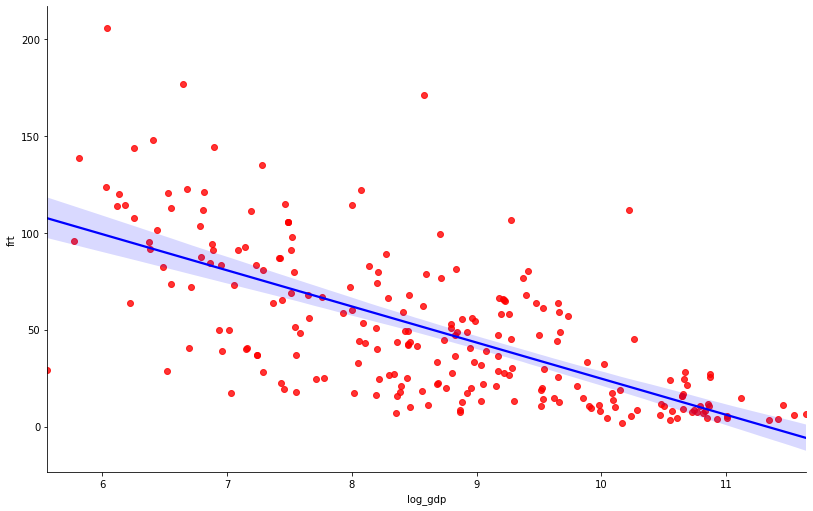

In [54]:
sns.lmplot(
    x='log_gdp', y='frt', data = df_2013_clean,
    fit_reg=True, 
    scatter_kws={'color':'red'}, 
    line_kws={'color':'blue'}, aspect = 1.6,
    height= 7)

In [61]:
dep_1, pred_1 = patsy.dmatrices('frt ~ log_gdp', df_2013_clean)
mod_1 = sm.OLS(dep_1, pred_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    frt   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     192.8
Date:                Sat, 26 Feb 2022   Prob (F-statistic):           3.79e-32
Time:                        03:00:41   Log-Likelihood:                -1093.8
No. Observations:                 229   AIC:                             2192.
Df Residuals:                     227   BIC:                             2198.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    211.2344     11.747     17.982      0.0

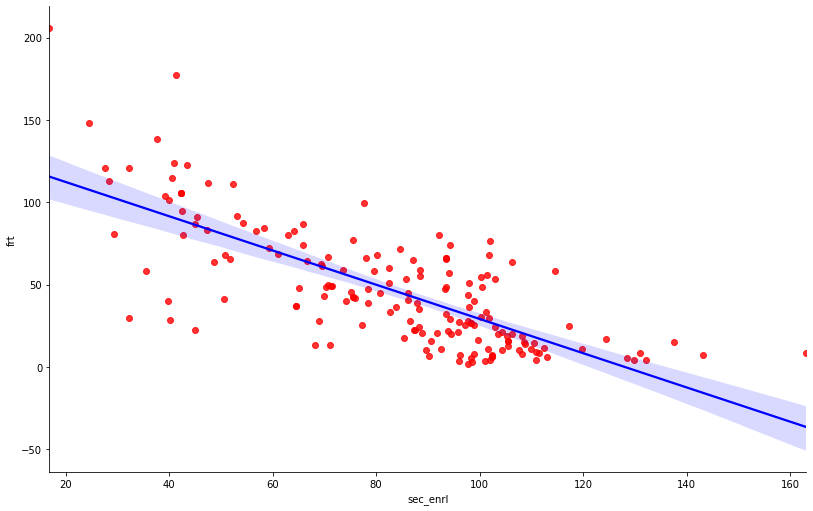

In [56]:
sns.lmplot(
    x='sec_enrl', y='frt', data = df_2013_clean,
    fit_reg=True, 
    scatter_kws={'color':'red'}, 
    line_kws={'color':'blue'}, aspect = 1.6,
    height= 7)

In [64]:
dep_2, pred_2 = patsy.dmatrices('frt ~ sec_enrl', df_2013_clean)
mod_2 = sm.OLS(dep_2, pred_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    frt   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     226.5
Date:                Sat, 26 Feb 2022   Prob (F-statistic):           3.32e-33
Time:                        03:02:41   Log-Likelihood:                -799.67
No. Observations:                 174   AIC:                             1603.
Df Residuals:                     172   BIC:                             1610.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    133.0576      5.995     22.194      0.0

*We advance the preliminary correlation check to include the key features of our desired regression model, the independet variable of interest (which is sec_enrl) and the key control variable (log_gdp)*. Results are shown below:

In [66]:
dep_3, pred_3 = patsy.dmatrices('frt ~ sec_enrl + log_gdp', df_2013_clean)
mod_3 = sm.OLS(dep_3, pred_3)
res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    frt   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     130.0
Date:                Sat, 26 Feb 2022   Prob (F-statistic):           7.80e-35
Time:                        03:03:01   Log-Likelihood:                -779.16
No. Observations:                 171   AIC:                             1564.
Df Residuals:                     168   BIC:                             1574.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    175.6131     13.341     13.163      0.0

<b>*A Final EDA Note:*</b> <br/>
At this stage, we are almost confident that all models above (mod_1, mod_2, mod_3) are theoretically wrong in that they bear very large omitted variable bias. The reason why we still carry out those analysis is to: first display the details not uncovered in the correlation heap map during screening, and second get a sense of whether we are heading in the right direction (if those models were incredibly bad to begin with, then improving the model will also be not-so-likely rewarding)
<br/>
<br/>
<b>*The Next steps:*</b> 
<br/>
Moving forward, we are looking for ways to eliminate OVB as much as possibe in which we hope to let other variables pick up the effect on secondary education enrollment rate and teenage fertility rate (reduce confounding). For now, our proposal is to , on top of means of control we have for now, adapt a entity-fixed effect where neighboring countries are grouped in one entity to pick up the 'cultural influence'. Our assumption here would be that different regions (i.e countries) have different social attitude towards teenage fertility (both the teenagers and their parents could vary in their ideaology with repsect to having kids early; or in some society, it is generally accepted or even expected that one to give birth during their late teenage.)